## Model Diagnostics

An informal notebook for model diagnostics based on predictions on held out test set

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

import src.globals as g

In [0]:
version_name_current = "01_02_01"
version_name_rem_production = "01_01_02"

In [0]:
# read in predictions on full test set for each model
predictions_current = pd.read_csv(
    str(g.GCS_ARTIFACT_PATH / version_name_current / "prediction_metrics_test_set.csv")
).query("fuel == 'total'")
# predictions_prod = pd.read_csv(
#     str(g.GCS_ARTIFACT_PATH / version_name_rem_production / "prediction_metrics_test_set.csv")
# ).query("fuel == 'total'")

# Calculate errors (not absolute)
predictions_current['error'] = predictions_current['prediction'] - predictions_current['actual']
predictions_current['savings_error'] = predictions_current['prediction_savings'] - predictions_current['actual_savings']

In [0]:
print(predictions_current.error.mean())
# Calculate mean error for each upgrade_id
predictions_current.groupby('upgrade_id')['error', 'savings_error'].agg(['mean', 'median', 'count'])

-276.7110594117852


/root/.ipykernel/1129/command-7152235726763485-3952956289:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  predictions_current.groupby('upgrade_id')['error', 'savings_error'].agg(


error                   savings_error                  
                  mean      median count          mean      median count
upgrade_id                                                              
0.00        -58.344007 -194.093701  7142      0.000000    0.000000  7142
0.01         47.686056 -118.646101  6523      0.000000    0.000000  6523
1.00       -335.369823 -347.834840  6988    273.292357  200.455178  6988
3.00       -562.119307 -440.404569  7142    503.775300  289.867569  7142
4.00       -564.434495 -421.197923  7142    506.090488  265.648759  7142
6.00        181.800372  -44.420473  7114   -238.273411 -107.881909  7114
9.00       -418.480314 -260.620470  7142    360.136307  153.648912  7142
11.05      -478.409192 -395.427994  7142    420.065185  284.936033  7142
11.07      -448.333508 -378.335308  6523    496.019564  321.884088  6523
13.01       581.211905 -101.973858  6988   -643.289370 -251.157990  6988
13.02      -417.173492 -366.389467  5232    559.710551  398.218726  5232
15.04      -491.760960 -382.652722  6491    434.728466  337.800986  6491
15.05      -438.838118 -352.532631  6491    381.805624  304.957929  6491
15.06      -379.893717 -322.600437  6491    322.861223  249.874068  6491
15.08      -453.497627 -377.690937  5679    398.143688  337.696731  5679

In [0]:
# filter to the 5th to 95th percentile for better plotting
def filter_by_percentiles(df, group_col, value_col, lower_pct=5, upper_pct=95):
    """Filter DataFrame to keep only values between percentiles for each group"""
    percentiles = df.groupby(group_col)[value_col].agg(
        [lambda x: np.percentile(x, lower_pct), 
         lambda x: np.percentile(x, upper_pct)]
    ).rename(columns={'<lambda_0>': 'lower', '<lambda_1>': 'upper'})
    
    # Merge percentiles back to original DataFrame
    df = df.merge(percentiles, left_on=group_col, right_index=True)
    
    # Filter rows
    filtered = df[(df[value_col] >= df['lower']) & 
                 (df[value_col] <= df['upper'])].copy()
    
    # Drop temporary columns
    filtered.drop(columns=['lower', 'upper'], inplace=True)
    
    return filtered

# Filter the DataFrame
filtered_df = filter_by_percentiles(
    predictions_current, 
    group_col='upgrade_id', 
    value_col='error',
    lower_pct=5,
    upper_pct=95
)

<Figure size 1200x600 with 0 Axes>

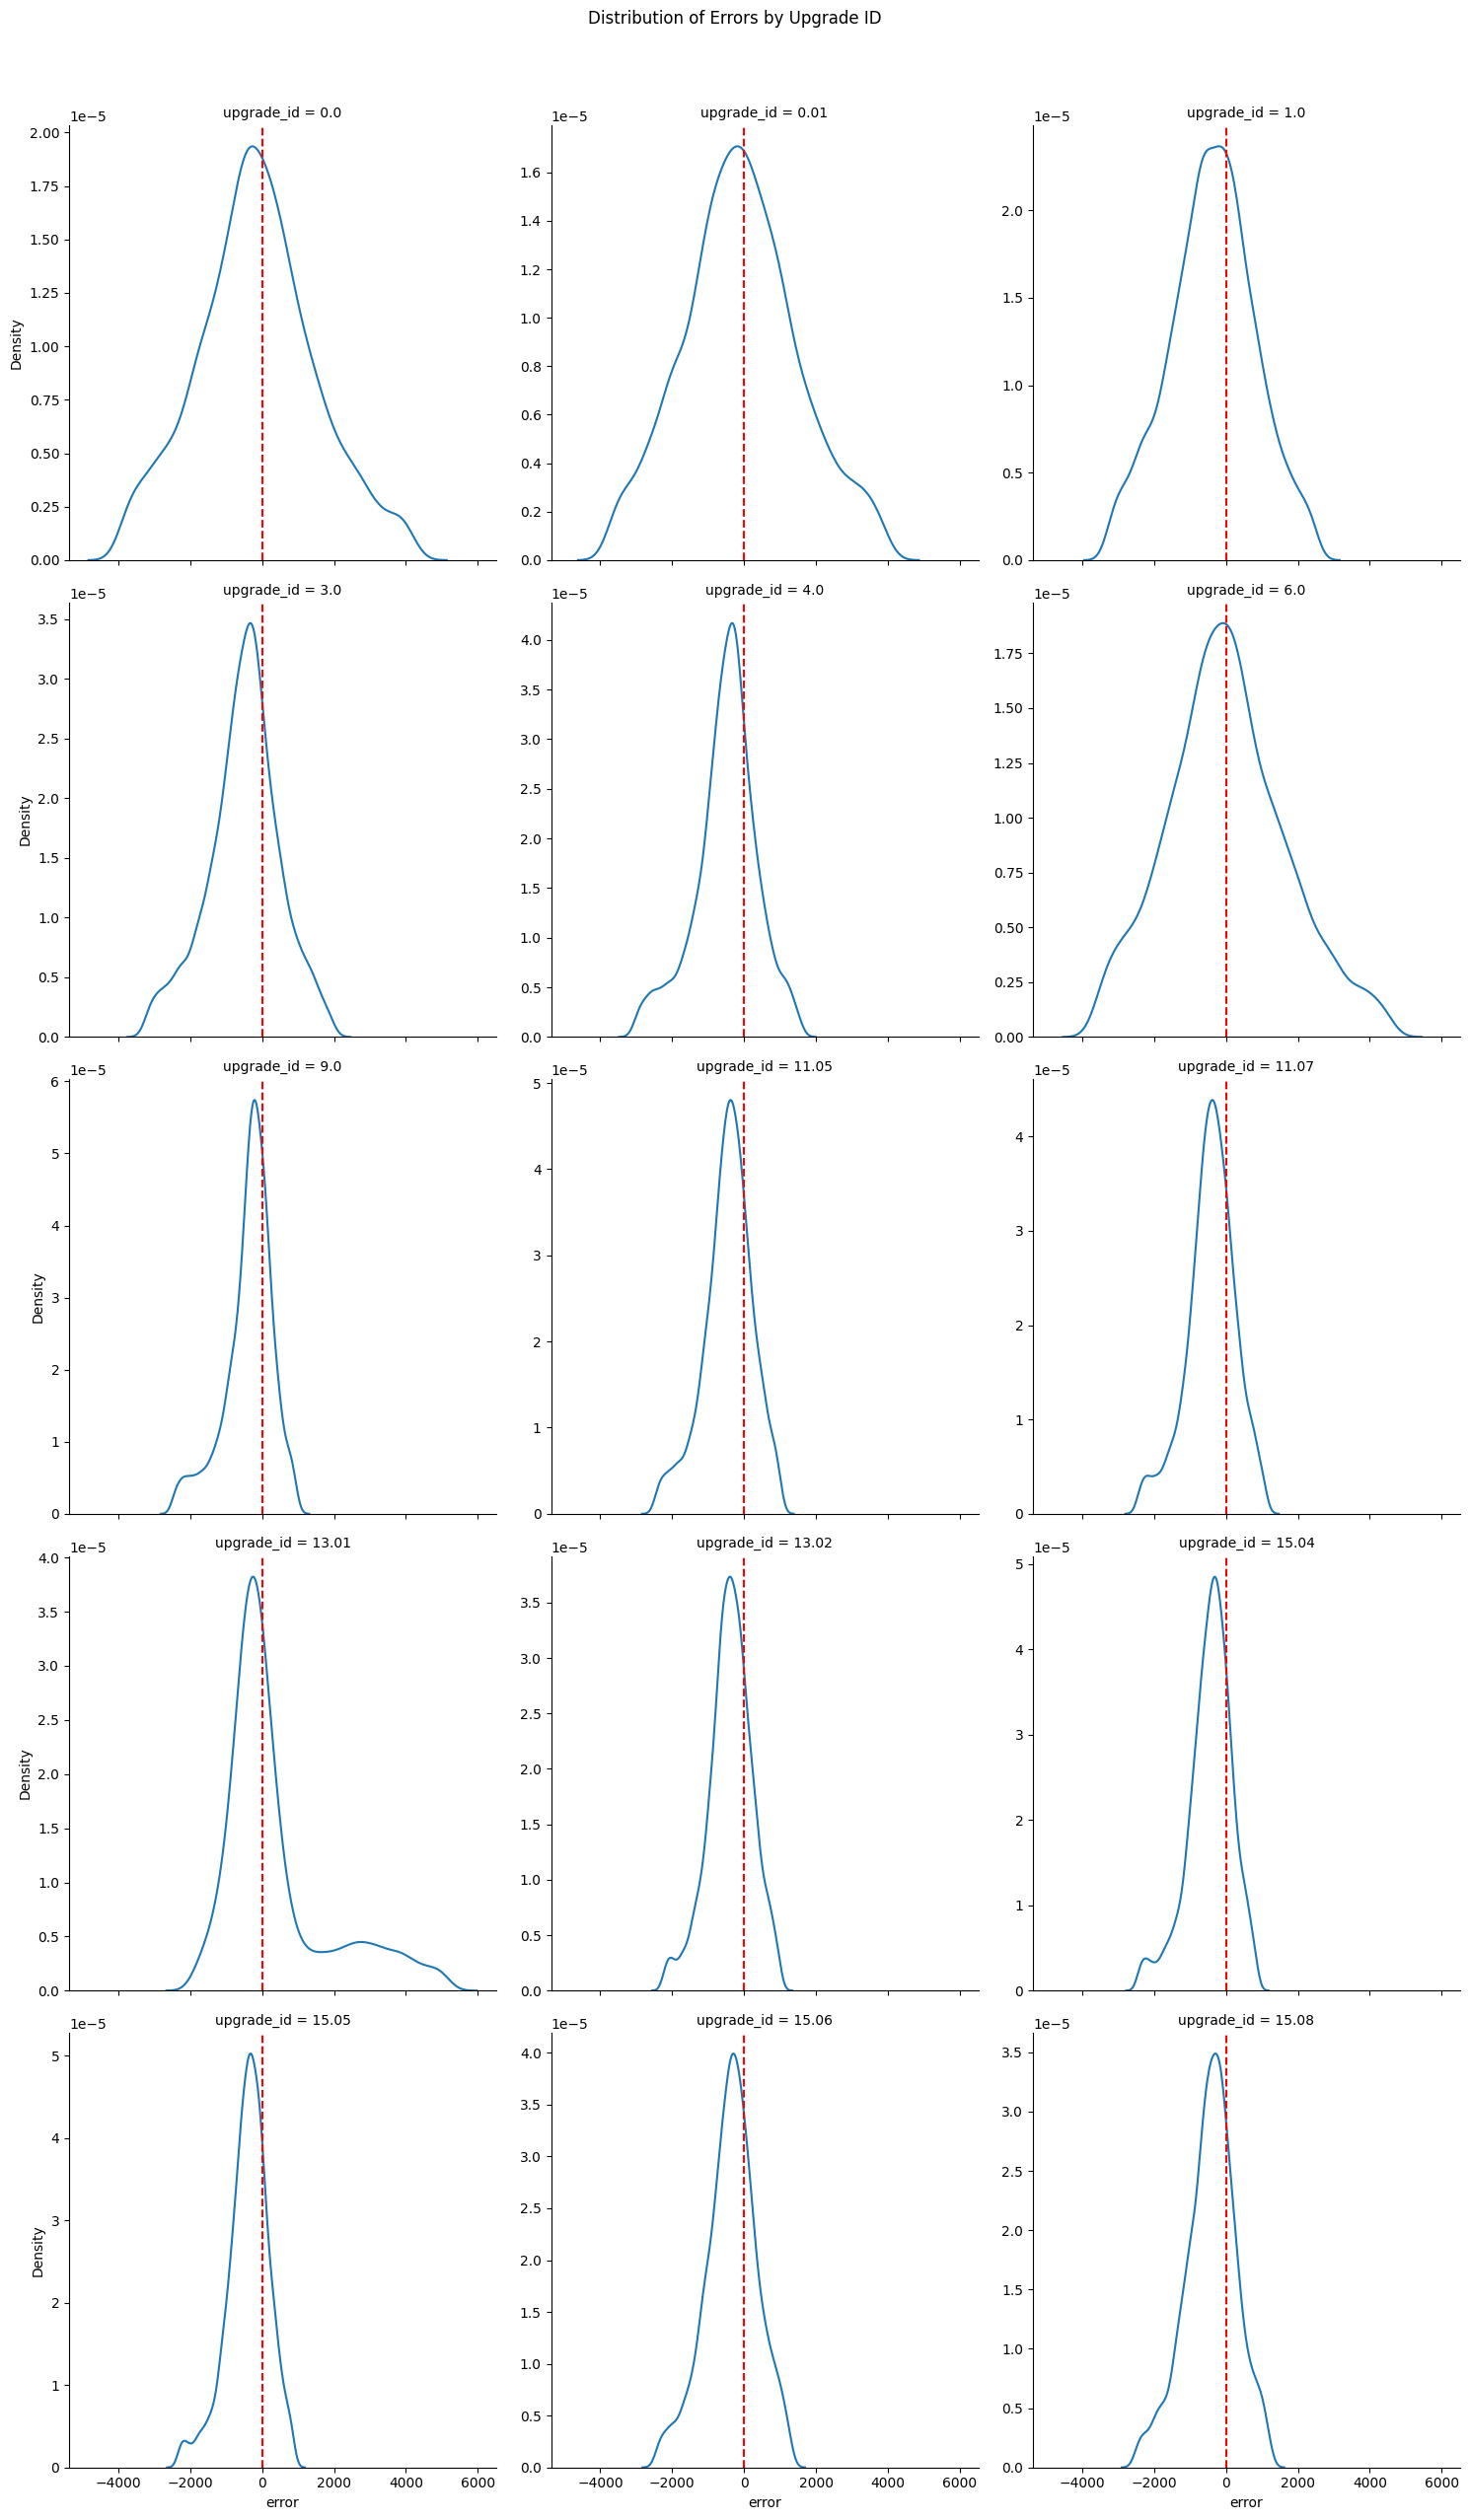

In [0]:
# Create distribution plot for each upgrade_id
plt.figure(figsize=(12, 6))
sns.displot(data=filtered_df, x='error', col='upgrade_id', col_wrap=3, 
            kind='kde', facet_kws={'sharey': False, 'sharex': True})

# Add vertical line at 0 to each subplot
for ax in plt.gcf().axes:
    ax.axvline(0, color='red', linestyle='--')

plt.suptitle('Distribution of Errors by Upgrade ID', y=1.02)
plt.tight_layout()
plt.show()

/databricks/python/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/databricks/python/lib/python3.10/site-packages/seaborn/regression.py:582: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


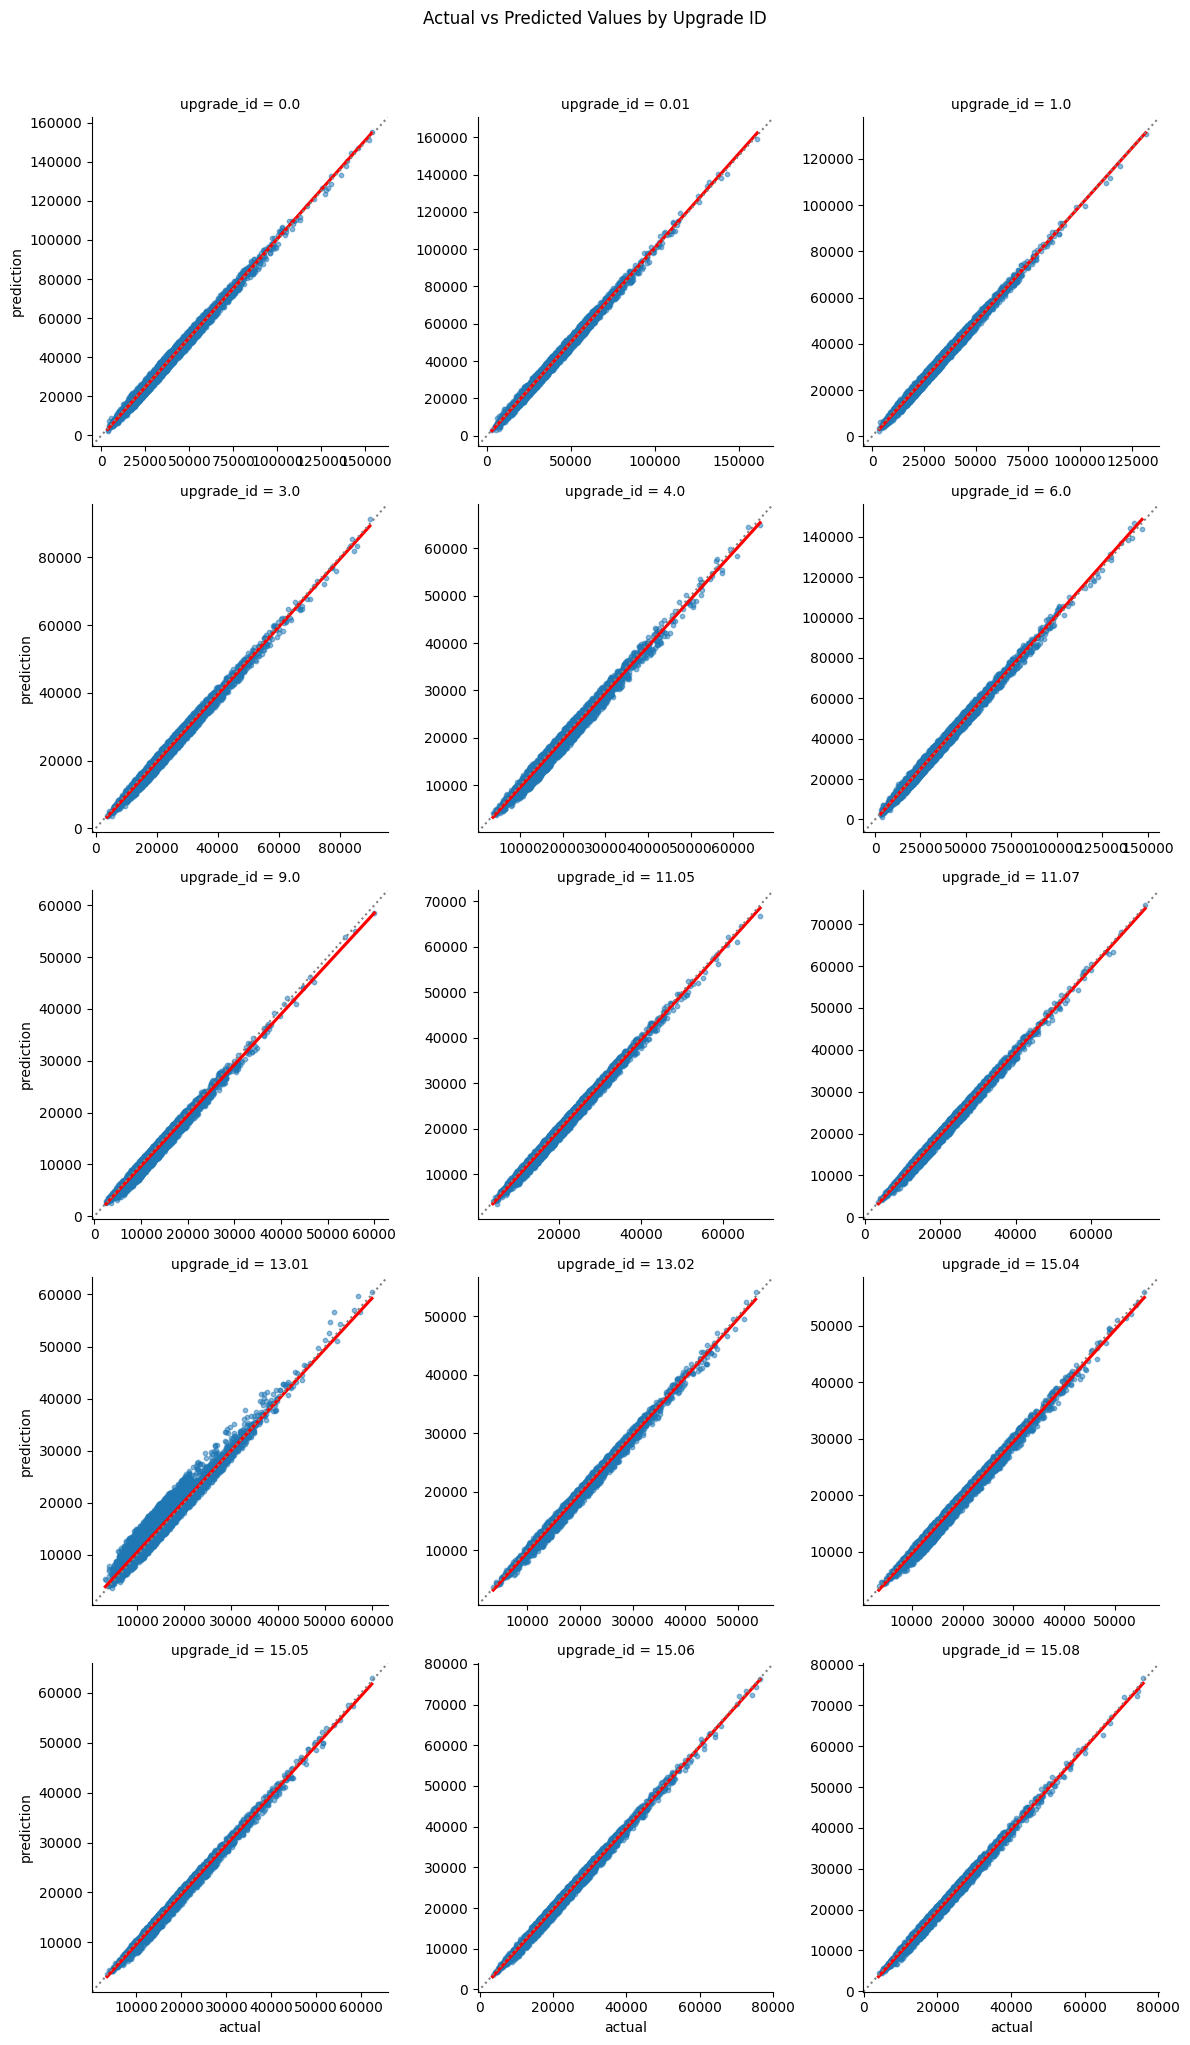

In [0]:
# Create scatter plot of actual vs prediction for each upgrade_id
g = sns.lmplot(data=filtered_df, x='actual', y='prediction', 
               col='upgrade_id', col_wrap=3, 
               scatter_kws={'alpha': 0.5,"s": 10}, line_kws={'color': 'red'},
               height=4, aspect=1, sharex=False, sharey=False)

# Add y=x line to each subplot
for ax in g.axes.flat:
    # Get axis limits
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    
    # Plot y=x line
    lims = [min(x0, y0), max(x1, y1)]
    ax.plot(lims, lims, ':', color='gray')
    
    # Reset limits
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle('Actual vs Predicted Values by Upgrade ID', y=1.02)
plt.tight_layout()
plt.show()

<Axes: xlabel='actual', ylabel='Count'>

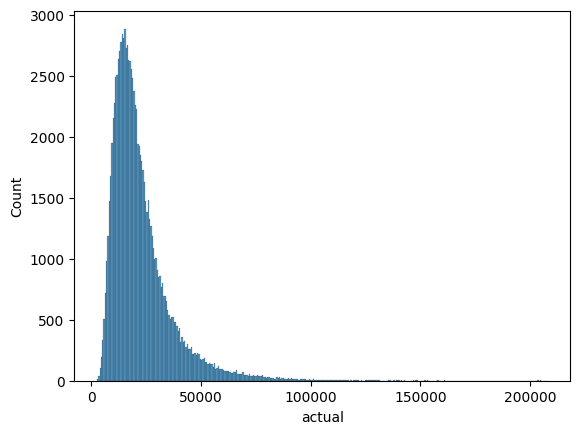

In [0]:
# look at overall shape of prediction distribution
sns.histplot(data=predictions_current[predictions_current.actual != 0], x='actual')

In [0]:
# Look at how often the ordering of the upgrades is wrong in terms of energy consumption magnitude
# 1.0 = perfect ordering within buildings
# 0.5 = random ordering (no better than chance)
# 0.0 = perfectly reversed ordering
def ordering_error_analysis(df):
    """
    Args:x
        df: DataFrame with columns ['building_id', 'upgrade_id', 'actual', 'prediction']
    Returns:
        - Global error rate (float)
        - DataFrame of upgrade_id misordering frequencies
    """
    total_pairs = 0
    incorrect_pairs = 0
    upgrade_errors = defaultdict(int)  # Tracks per-upgrade errors
    upgrade_counts = defaultdict(int)  # Tracks per-upgrade total comparisons

    for _, group in df.groupby(['building_id', 'building_set']):
        upgrades = group['upgrade_id'].unique()
        if len(upgrades) < 2:
            continue  # Skip buildings with only one upgrade

        for u1, u2 in combinations(upgrades, 2):
            # Get actual/predicted values for the pair
            u1_data = group[group['upgrade_id'] == u1].iloc[0]
            u2_data = group[group['upgrade_id'] == u2].iloc[0]

            pred_order = u1_data['prediction'] - u2_data['prediction']
            actual_order = u1_data['actual'] - u2_data['actual']

            # Check if ordering is wrong
            if (pred_order * actual_order) < 0:
                incorrect_pairs += 1
                upgrade_errors[u1] += 1
                upgrade_errors[u2] += 1
            total_pairs += 1
            upgrade_counts[u1] += 1
            upgrade_counts[u2] += 1

    # Calculate global error rate
    global_error_rate = incorrect_pairs / total_pairs if total_pairs > 0 else 0.0

    # Calculate per-upgrade error rates
    upgrade_error_rates = {
        upgrade: (upgrade_errors[upgrade] / upgrade_counts[upgrade]) 
        for upgrade in upgrade_counts
    }
    upgrade_error_df = pd.DataFrame({
        'upgrade_id': list(upgrade_error_rates.keys()),
        'error_rate': list(upgrade_error_rates.values()),
        'occurrences': list(upgrade_counts.values())
    }).sort_values('error_rate', ascending=False)

    return global_error_rate, upgrade_error_df

# takes a long time so just run on a subser
global_error, upgrade_errors = ordering_error_analysis(predictions_current[predictions_current.building_id < 100000])
print(f"Global ordering error rate: {global_error:.2%}")
print(upgrade_errors.head())  # Show worst-performing upgrades

Global ordering error rate: 3.86%
    upgrade_id  error_rate  occurrences
5        15.08    0.076398         6008
1        11.07    0.064656         6697
3        15.05    0.060968         6692
2        15.04    0.058876         6692
14       13.02    0.058698         5622
